# HRV-Stress_hrv

## make peak data data

In [3]:
import os
import os.path as osp
import pandas as pd
import numpy as np
import copy
from scipy import signal
from scipy.interpolate import Akima1DInterpolator
import pickle
import math

In [4]:
path_data = 'data/individual'
name_input_file = 'heartrate.csv' # public raw data of nback

In [5]:
subject_list = os.listdir(path_data)

In [6]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [9]:
moving_average_window = 330 # 330 ms
peak_distance = 350 # 350 ms
max_hrv_window = 60000
# for detrending using interpolator
step_size = 10 # 10 ms
shift = (moving_average_window//step_size)-1

# # for detrending without interpolator
# step_size = 1 # 1 ms

In [5]:
for subject_name in subject_list:
    print(subject_name)
    
    # read
    df = pd.read_csv(osp.join(path_data,subject_name,name_input_file))
    
    # check n-back first time_stamp and remove all before first - window_size - max_hrv_window
    df_nback = pd.read_csv(osp.join(path_data,subject_name,'nback.csv'))
    start_time = df_nback['time_stamp'].iloc[0] - moving_average_window - max_hrv_window
    end_time = df_nback['time_stamp'].iloc[-1]
    
    for idx, val in enumerate(df['time_stamp']):
        if val >= start_time:
            break
    if idx > 0:
        idx -= 1
    df.drop(df.index[0:idx], inplace = True)
    
    for idx, val in enumerate(df['time_stamp'][::-1]):
        if val <= end_time:
            break
    if idx > 0:
        idx -= 1
    df.drop(df.index[-idx::], inplace = True)
    
    df.reset_index(inplace=True,drop=True)

    # detrending using interpolator (make data evenly spaced)
    # smoothing using akima, with step_size correction
    start_time = df['time_stamp'].iloc[0]
    start_time = (math.ceil(start_time/step_size))*step_size
    end_time = df['time_stamp'].iloc[-1]
    end_time = (math.floor(end_time/step_size))*step_size
    
    time_stamp_smooth = np.linspace(start_time, end_time, num=(end_time-start_time)//step_size+1, endpoint=True)

    red_interpolator = Akima1DInterpolator(df['time_stamp'].to_numpy(), df['red'].to_numpy())
    red = red_interpolator(time_stamp_smooth)

    # rolling moving average
    red_average = moving_average(red, n=moving_average_window//step_size)
    red_detrend = red[shift::] - red_average
    time_stamp_shift = time_stamp_smooth[shift::]

#     # detrending without interpolator (without making time_stamp evenly spaced)
#     # time window based interpolator
#     start_time = df['time_stamp'].iloc[0]
#     start_time = start_time + moving_average_window
    
#     for idx, val in df['time_stamp'].iteritems():
#         if val >= start_time:
#             break
#     if idx > 0:
#         idx -= 1
    
#     red = df['red'].to_numpy()
#     time_stamp = df['time_stamp'].to_numpy()
#     red_shift = df['red'][idx:].to_numpy()
#     time_stamp_shift = df['time_stamp'][idx:].to_numpy()
#     red_moving_average = np.array([np.mean(red[(time_stamp > t-moving_average_window) * (time_stamp <= t)]) for t in time_stamp_shift])
#     red_detrend = red_shift - red_moving_average

    # save detrended signal
    with open(osp.join(path_data,subject_name,'red_detrend_and_time_stamp_shift.pickle'), 'wb') as handle:
        pickle.dump([red_detrend,time_stamp_shift], handle, protocol=pickle.HIGHEST_PROTOCOL)

s01
s02
s03
s04
s05
s06
s07
s08
s09
s10
s11
s12
s13
s14
s15
s16
s17
s18
s19
s20
s21
s22
s23
s24
s25
s26
s27
s28
s29
s30
s31
s32
s33
s34
s35
s36
s37
s38
s39


In [10]:
for subject_name in subject_list:
    with open(osp.join(path_data,subject_name,'red_detrend_and_time_stamp_shift.pickle'), 'rb') as handle:
        red_detrend, time_stamp_shift = pickle.load(handle)
    
    # smoothing using akima (mostly for unevenly spaced data)
    if step_size > 1:
        start_time = time_stamp_shift[0]
        end_time = time_stamp_shift[-1]
        time_stamp_smooth = np.linspace(start_time, end_time, num=int(end_time-start_time)//step_size, endpoint=True)
        red_interpolator = Akima1DInterpolator(time_stamp_shift, red_detrend)
        red_smooth = red_interpolator(time_stamp_smooth)
    else:
        time_stamp_smooth = time_stamp_shift
        red_smooth = red_detrend
    
    # peak finder
    peaks, _ = signal.find_peaks(red_smooth, distance=peak_distance//step_size)

    # time_stamp of peak
    df_time_stamp_peak = pd.DataFrame({'time_stamp':time_stamp_smooth[peaks]})
    
    # save
    df_time_stamp_peak.to_csv(osp.join(path_data,subject_name,'peaks.csv'), index=False)

## Peaks Visualization

[    23     85    145 ... 117422 117476 117535]


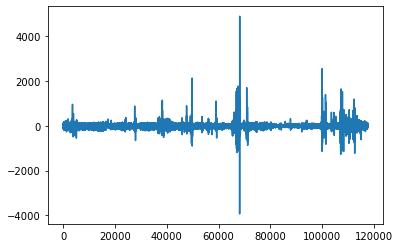

In [11]:
import matplotlib.pyplot as plt
plt.plot(red_smooth)
print(peaks)

In [12]:
for subject_name in subject_list:
    with open(osp.join(path_data,subject_name,'red_detrend_and_time_stamp_shift.pickle'), 'rb') as handle:
        red_detrend, time_stamp_shift = pickle.load(handle)
    break

In [13]:
time_stamp_shift[0]

1569164400270.0